### **1. Import the Required Libraries**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [3]:
train_dataset_path = '/kaggle/input/fundus-pytorch/train'
validation_dataset_path = '/kaggle/input/fundus-pytorch/val'

#### **ii. Load Image Datasets and Apply Augmentations**

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
image_size = (128,128)

Loading the training dataset and applying augmentations on it.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    fill_mode='nearest',)
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 8621 images belonging to 2 classes.


Loading the validation dataset.

In [6]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 5747 images belonging to 2 classes.


#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [7]:
label_mapping = {0: "normal", 1: "glaucoma"}
labels = {label_mapping[value]: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")


Label Mappings for classes present in the training and validation datasets

normal : 0
glaucoma : 1


### **3. Plotting Sample Training Images**

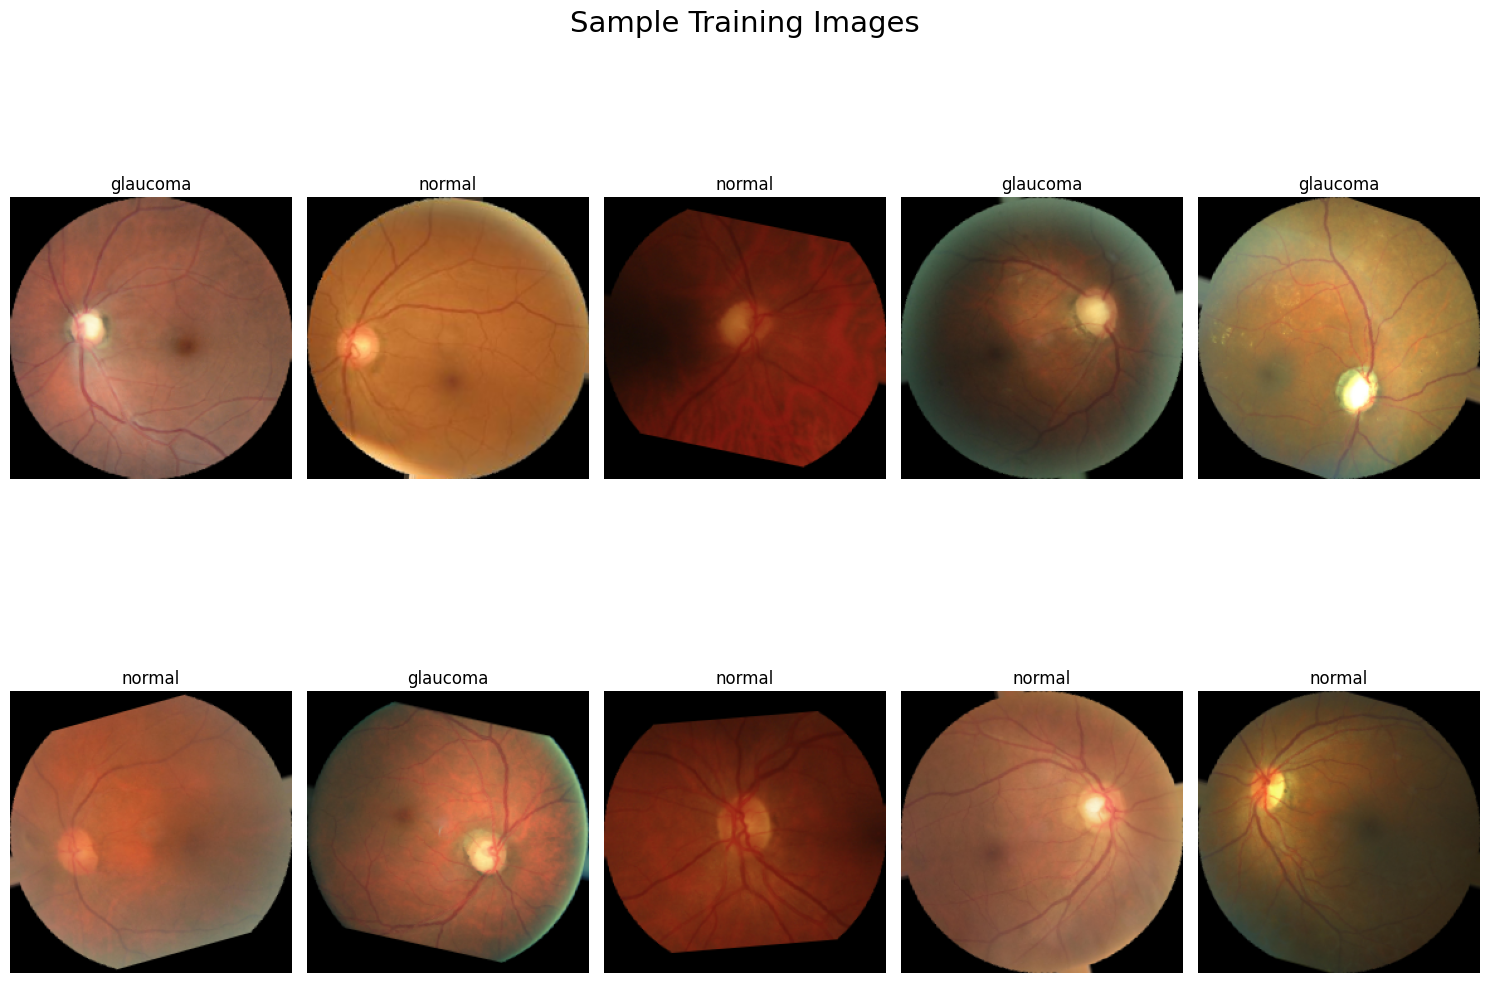

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label_index = np.argmax(train_generator[0][1][idx])
        label = list(labels.keys())[label_index]  # Get the key corresponding to the label index
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### **4. Training a CNN Model**

Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

#### **i.Create a Xception Build Model**

In [9]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from keras.applications.xception import Xception, preprocess_input

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

83683744/83683744 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

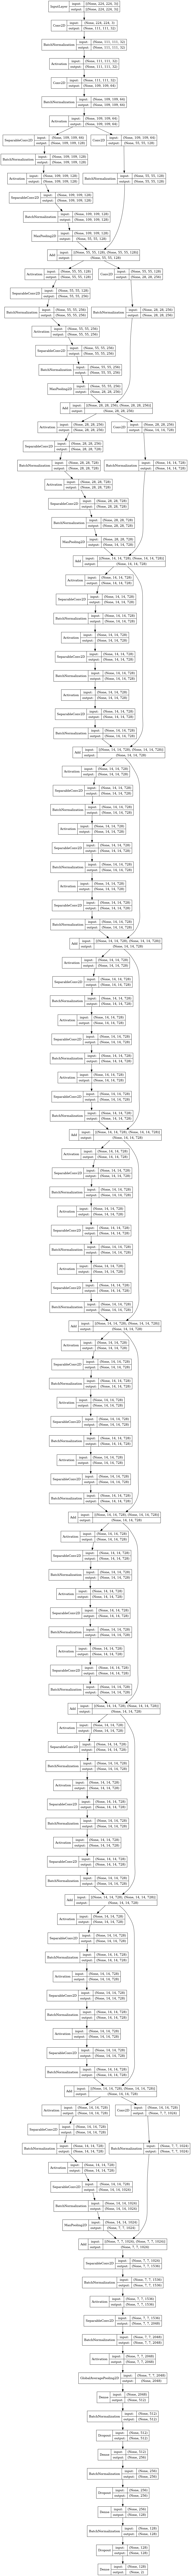

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, expand_nested=True, show_shapes=True, show_layer_names=False)

#### **ii. Defining Callbacks**

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **iii. Defining the Optimizer**

In [13]:
optimizer = Adam(learning_rate=0.001)

#### **iv. Compile the Model**

In [14]:
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

#### **v. Training the Model**

In [15]:
# training
history = model.fit(train_generator,batch_size=32,epochs=50,
        validation_data=validation_generator,verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
270/270 - 340s - loss: 0.7311 - accuracy: 0.6698 - val_loss: 0.4724 - val_accuracy: 0.7729 - lr: 0.0010 - 340s/epoch - 1s/step
Epoch 2/50
270/270 - 228s - loss: 0.5371 - accuracy: 0.7434 - val_loss: 0.4401 - val_accuracy: 0.7961 - lr: 0.0010 - 228s/epoch - 844ms/step
Epoch 3/50
270/270 - 228s - loss: 0.4853 - accuracy: 0.7745 - val_loss: 0.4628 - val_accuracy: 0.7799 - lr: 0.0010 - 228s/epoch - 844ms/step
Epoch 4/50
270/270 - 235s - loss: 0.4719 - accuracy: 0.7853 - val_loss: 0.4320 - val_accuracy: 0.7957 - lr: 0.0010 - 235s/epoch - 872ms/step
Epoch 5/50
270/270 - 239s - loss: 0.4592 - accuracy: 0.7920 - val_loss: 0.4126 - val_accuracy: 0.8091 - lr: 0.0010 - 239s/epoch - 885ms/step
Epoch 6/50
270/270 - 233s - loss: 0.4527 - accuracy: 0.7952 - val_loss: 0.4138 - val_accuracy: 0.8136 - lr: 0.0010 - 233s/epoch - 861ms/step
Epoch 7/50
270/270 - 232s - loss: 0.4438 - accuracy: 0.7963 - val_loss: 0.4110 - val_accuracy: 0.8143 - lr: 0.0010 - 232s/epoch - 857ms/step
Epoch 8/50
270/2

### **5. Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

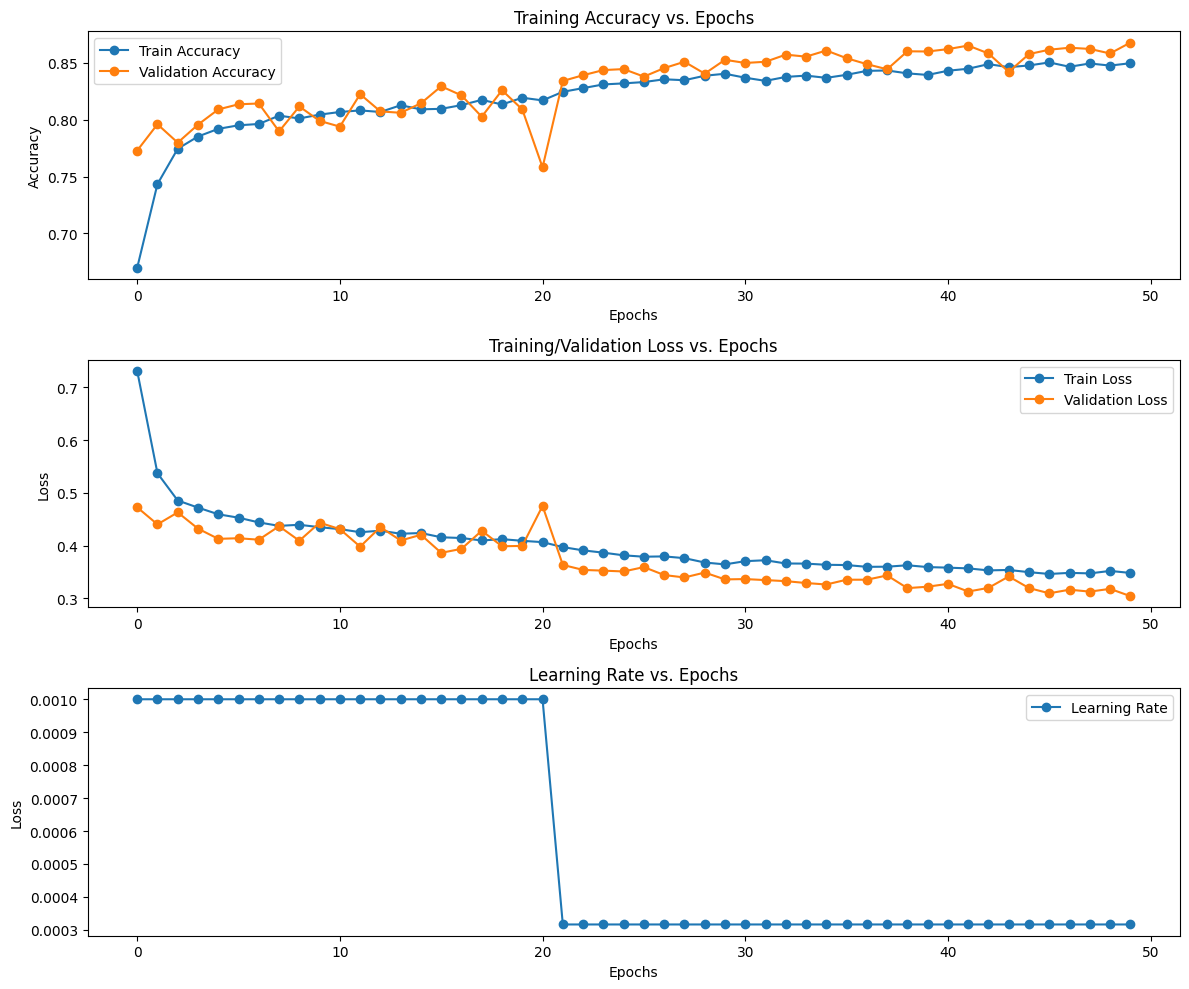

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### **6. Testing the Model on Test Set**

Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [18]:
test_dataset = '/kaggle/input/fundus-pytorch/test'

In [19]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 2874 images belonging to 2 classes.


### **7. Model Prediction on the Test Dataset**

In [20]:
predictions = model.predict(test_generator)


90/90 [==============================] - 44s 478ms/step


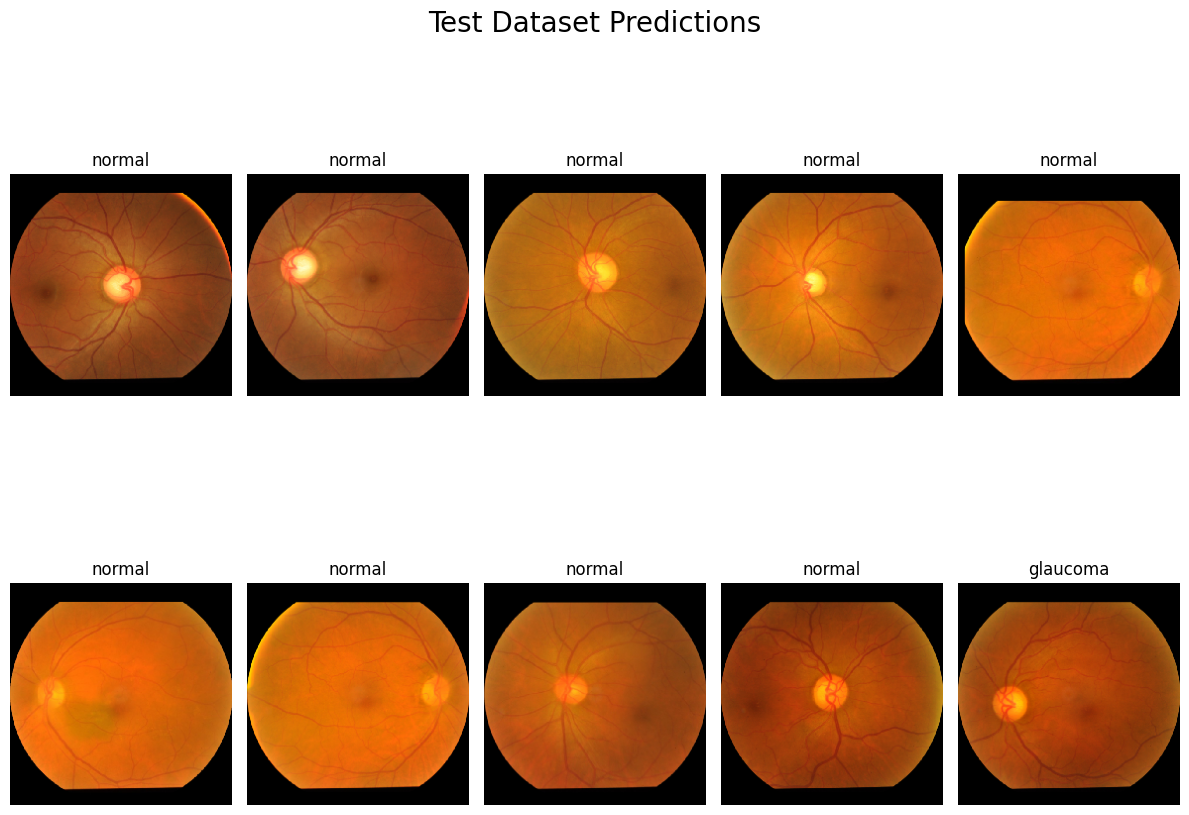

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = np.argmax(predictions[idx])
        label = list(labels.keys())[predicted_label]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

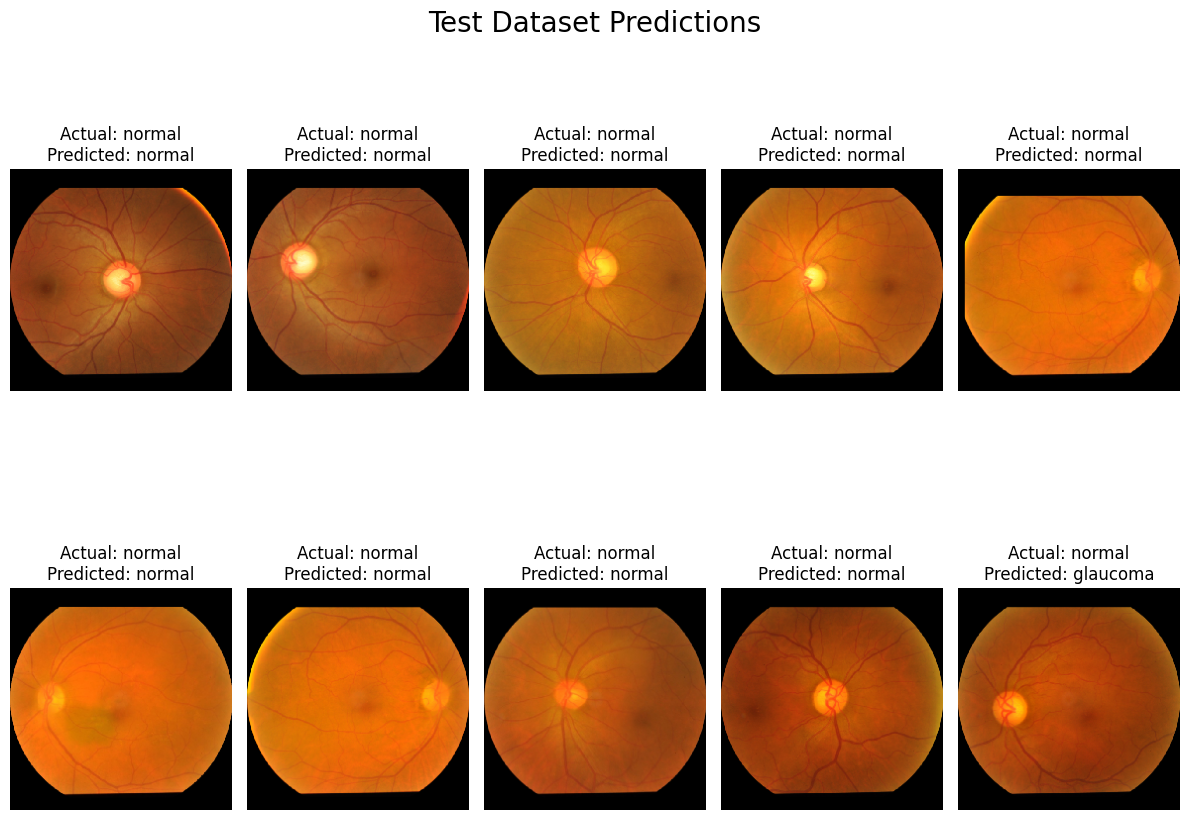

In [22]:


fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        # Extract the predicted label index from the predictions
        predicted_label_index = np.argmax(predictions[idx])
        
        # Get the corresponding label from the dictionary of labels
        predicted_label = list(labels.keys())[predicted_label_index]
        
        # Get the actual label from the generator
        actual_label_index = np.argmax(test_generator[0][1][idx])
        actual_label = list(labels.keys())[actual_label_index]
        
        # Display the actual and predicted labels
        ax[i, j].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        
        # Display the image
        ax[i, j].imshow(test_generator[0][0][idx])
        
        # Turn off axis
        ax[i, j].axis("off")
        
        # Move to the next image index
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()


In [23]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)


90/90 [==============================] - 30s 328ms/step - loss: 0.3077 - accuracy: 0.8706


In [24]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.3076803982257843
Test Accuracy: 0.8705636858940125


The test loss and test accuracy is the same as validation loss and validation accuracy at the last step since the testing and validation datasets are same.

### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [25]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

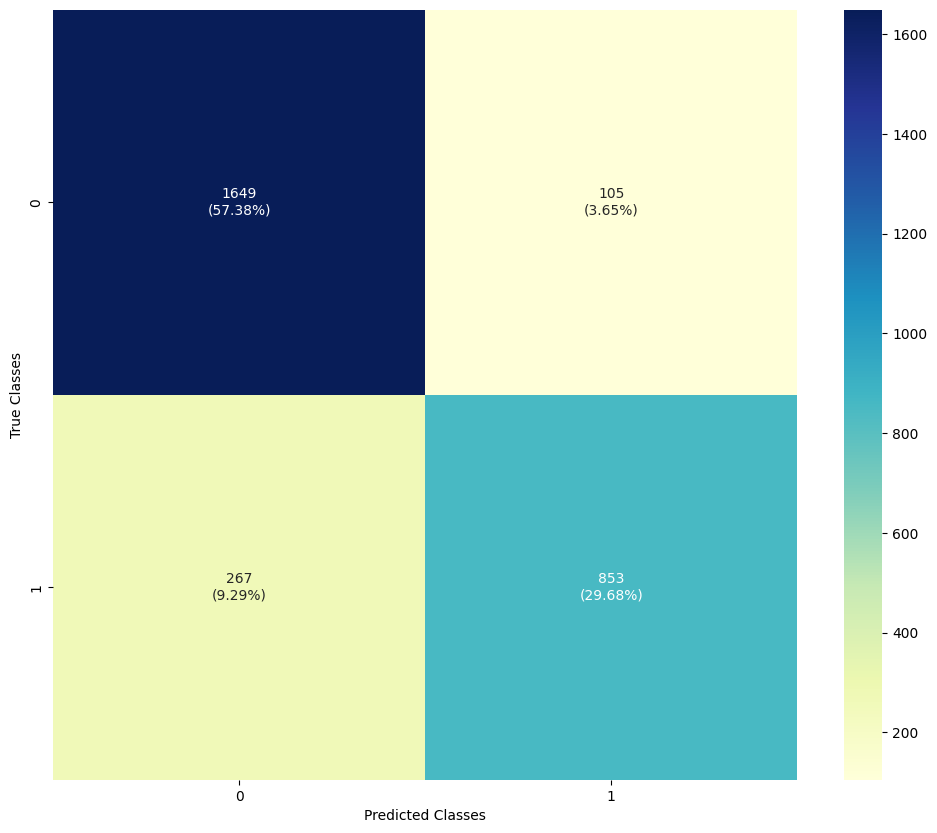

In [26]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [27]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1754
           1       0.89      0.76      0.82      1120

    accuracy                           0.87      2874
   macro avg       0.88      0.85      0.86      2874
weighted avg       0.87      0.87      0.87      2874



### **9. Wrong Predictions**

Let's see where the model has given wrong predictions and what were the actual predictions on those images.

In [28]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [29]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

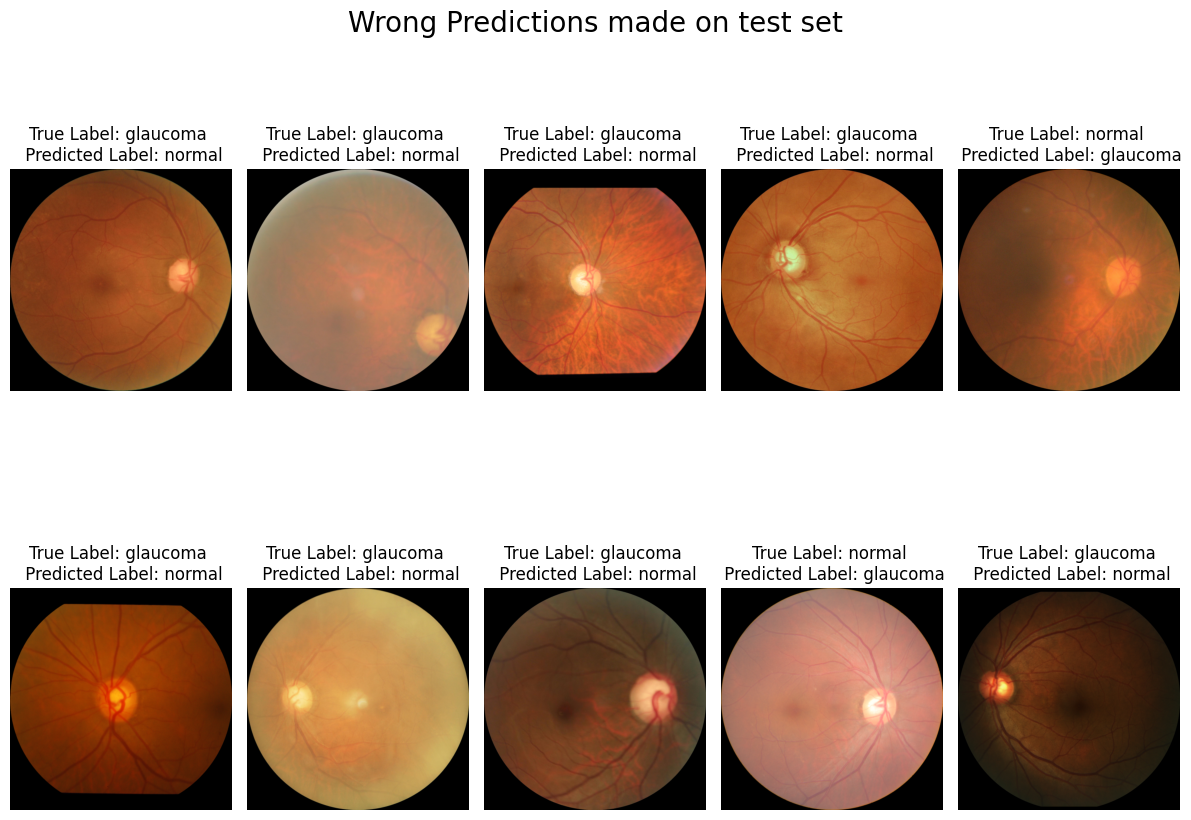

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = true_index
        label_1 = list(labels.keys())[true_label]
        predicted_index = y_pred_errors[idx]
        predicted_label = list(labels.keys())[predicted_index]
        ax[i, j].set_title(f"True Label: {label_1} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()